In [56]:
# Importing Libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import statsmodels.formula.api as smf
from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import SelectKBest, f_classif,chi2
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import ensemble
from sklearn.metrics import auc, precision_recall_curve
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import  silhouette_score
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.cluster import MiniBatchKMeans

import warnings
warnings.filterwarnings('ignore')
sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (20.0, 20.0)
plt.rcParams.update({'font.size': 25})
%matplotlib inline

In [57]:
#Loading Dataset

nj_transit = pd.read_csv("2019_04.csv")

In [58]:
df = pd.DataFrame(nj_transit)

# 1.1 Data Background

NJ Transit is the second largest commuter rail network in the United States by ridership; it spans New Jersey and connects the state to New York City. On the Northeast Corridor, the busiest passenger rail line in the United States, Amtrak also operates passenger rail service; together, NJ Transit and Amtrak operate nearly 750 trains across the NJ Transit rail network.

Despite serving over 300,000 riders on the average weekday, no granular, trip-level performance data is publicly available for the NJ Transit rail network or Amtrak. This datasets aims to publicly provide such data.

This real-life dataset can be found on Kaggle. Here is the link:

https://www.kaggle.com/pranavbadami/nj-transit-amtrak-nec-performance

# 1.1.b What is in the data?

I categorized the data to give a better understanding of the general point of view. Overall, our data is consist of 13 features.

##### Time
    date:              Date of operation according to the 27-hour NJ Transit schedule. From 04/09/18 4:00 to 04/10/18 4:00.
    scheduled_time:    The scheduled departure time out of the "to" stop.
    actual_time:       The actual departure time out of the "to" stop.
    delay_minutes:     The difference between actual_time and scheduled_time, in minutes.
       
##### Train information
    train_id:          Train number in the NJT or Amtrak system.
    line:              Name of the line that the train operates in.
    type:              NJ Transit or Amtrak.
    status:            Train's operation status. Departed, delayed or canceled.

##### Operation information
    stop_sequence:     Scheduled stop number.  
    from:              Station the train is traveling from for the stop in the current row.  
    from_id:           Station id for the "from" station.
    to:                Station the train is arriving to for the stop in the current row.
    to_id:             Station id for the "to" station.        

# The Goal

#### Unsupervised Learning

My goal for the this part of the capstone project is to answer two specific question which could be used for a better service.

 - 1. Which day of the week has the longest delays in each cluster?
 - 2. Does the stop sequence affect the status of trains in each cluster?
 

#### Supervised Learning

My goal is to create a final model that finds the train status effectively. I perform several machine learning techniques to find the best performer and create my final model.

# 1.2 Exploratory Data Analysis

In [59]:
#Checking the number of columns and rows to see how big is our dataset
df.shape

(238693, 13)

In [60]:
# Looking at the head of the dataset to have a better understanding
df.head()

,date,train_id,stop_sequence,from,from_id,to,to_id,scheduled_time,actual_time,delay_minutes,status,line,type
0,2019-04-01,4393,1.0,Long Branch,74,Long Branch,74,2019-04-02 00:08:00,2019-04-02 00:07:06,0.000000,departed,No Jersey Coast,NJ Transit
1,2019-04-01,4393,2.0,Long Branch,74,Elberon,40,2019-04-02 00:12:00,2019-04-02 00:13:09,1.150000,departed,No Jersey Coast,NJ Transit
2,2019-04-01,4393,3.0,Elberon,40,Allenhurst,4,2019-04-02 00:16:00,2019-04-02 00:18:07,2.116667,departed,No Jersey Coast,NJ Transit
3,2019-04-01,4393,4.0,Allenhurst,4,Asbury Park,8,2019-04-02 00:20:00,2019-04-02 00:21:12,1.200000,departed,No Jersey Coast,NJ Transit
4,2019-04-01,4393,5.0,Asbury Park,8,Bradley Beach,22,2019-04-02 00:23:00,2019-04-02 00:23:10,0.166667,departed,No Jersey Coast,NJ Transit


In [61]:
#Checking info of data as data types and rows n cols
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 238693 entries, 0 to 238692
Data columns (total 13 columns):
date              238693 non-null object
train_id          238693 non-null object
stop_sequence     213163 non-null float64
from              238693 non-null object
from_id           238693 non-null int64
to                238693 non-null object
to_id             238693 non-null int64
scheduled_time    213163 non-null object
actual_time       238693 non-null object
delay_minutes     213163 non-null float64
status            238693 non-null object
line              238693 non-null object
type              238693 non-null object
dtypes: float64(2), int64(2), object(9)
memory usage: 23.7+ MB


 - Most features are objects which will make the data harder to use later. I will have to assign dummies to make them useful for my models.

In [62]:
#Checking the number of distinct values in each column.
df.nunique()

date                  30
train_id            1241
stop_sequence         26
from                 157
from_id              157
to                   157
to_id                157
scheduled_time     37851
actual_time       162435
delay_minutes       2012
status                 3
line                  25
type                   2
dtype: int64

-  We can drop From and To because they already have their unique From_ID and To_ID as dummies to be used.

In [63]:
# Looking up to the unique values of a feature
df['line'].unique()

array(['No Jersey Coast', 'Northeast Corrdr', 'Bergen Co. Line ',
       'Morristown Line', 'Gladstone Branch', 'Pascack Valley',
       'Montclair-Boonton', 'KEYSTONE', 'ACELA EXPRESS', 'Raritan Valley',
       'Main Line', 'REGIONAL', 'AMTRAK', 'Amtrak', 'VERMONTER    -R',
       'SILVER METEOR-R', 'SILVER STAR  -R', 'CRESCENT', 'PENNSYLVANIAN',
       'CAROLINIAN', 'Palmetto', 'AMTRAK REGIONAL', 'Meadowlands Rail',
       'Princeton Shuttle', 'Acela Express'], dtype=object)

In [64]:
# Looking up to the unique values of a feature
df['type'].unique()

array(['NJ Transit', 'Amtrak'], dtype=object)

In [65]:
# Looking up to the unique values of a feature
df['status'].unique()

array(['departed', 'estimated', 'cancelled'], dtype=object)

There don't seem to be any outliers juding from the max, standard deviations, and means except for amount. However, amount having outliers shouldn't be too much of a problem for what I'm trying to do.

In [66]:
#Exploring the total number of delay minutes by the line

df.groupby(['line'],)['delay_minutes'].count().sort_values(ascending=False)[0:20]

line
Morristown Line      35612
Northeast Corrdr     35415
No Jersey Coast      33082
Main Line            20955
Montclair-Boonton    20303
Bergen Co. Line      20163
Gladstone Branch     18608
Pascack Valley       15010
Raritan Valley       13529
Princeton Shuttle      486
AMTRAK                   0
AMTRAK REGIONAL          0
Acela Express            0
Amtrak                   0
CAROLINIAN               0
CRESCENT                 0
VERMONTER    -R          0
KEYSTONE                 0
Meadowlands Rail         0
SILVER STAR  -R          0
Name: delay_minutes, dtype: int64

- Amtrak schedules are not contained in the dataset.

In [67]:
#Amtrak schedules are not contained in the dataset.Only NJ Transit
df = df[df['type'] == 'NJ Transit']

In [68]:
#Checking missing values in the dataset
df.isnull().values.any()

True

In [69]:
#Checking missing values in the dataset
null_counts = df.isnull().sum()
null_counts[null_counts > 0].sort_values(ascending=False)

delay_minutes     12981
scheduled_time    12981
stop_sequence     12981
dtype: int64

- There is some NA values that needs to be cleared up.

In [70]:
# Dropping NULL values
df = df.dropna()

There are huge amount of NULLs in our dataset so it would be hard to replace them with the mean in terms of accuracy and they cannot be neglected. Dropping them is the best option.

In [71]:
df.describe(exclude=[np.number])

,date,train_id,from,to,scheduled_time,actual_time,status,line,type
count,213163,213163,213163,213163,213163,213163,213163,213163,213163
unique,30,998,156,156,37851,150331,3,10,1
top,2019-04-12,1087,New York Penn Station,New York Penn Station,2019-04-11 18:04:00,2019-04-23 19:04:08,departed,Morristown Line,NJ Transit
freq,8473,572,7722,7705,19,28,193744,35612,213163


In [72]:
x = df.groupby(['line', 'status']).size().unstack()
x['cancelled']/(x['departed']+x['estimated'])

line
Bergen Co. Line      0.005786
Gladstone Branch     0.006327
Main Line            0.005181
Montclair-Boonton    0.008795
Morristown Line      0.012712
No Jersey Coast      0.018974
Northeast Corrdr     0.003684
Pascack Valley       0.002404
Princeton Shuttle         NaN
Raritan Valley       0.004007
dtype: float64

- The cancel rate seems to be low for all trips. 

In [73]:
x['cancelled']

line
Bergen Co. Line      116.0
Gladstone Branch     117.0
Main Line            108.0
Montclair-Boonton    177.0
Morristown Line      447.0
No Jersey Coast      616.0
Northeast Corrdr     130.0
Pascack Valley        36.0
Princeton Shuttle      NaN
Raritan Valley        54.0
Name: cancelled, dtype: float64

- Princeton has no cancellation which is very impressive.

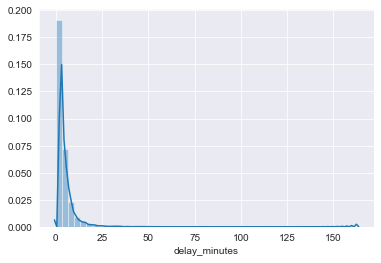

In [74]:
sns.distplot(df['delay_minutes'])

- As shown in the summary and the chart there are some outliers with very large delays.

In [75]:
#Getting rid of outliers 
from scipy.stats.mstats import winsorize

df['w_delay_minutes'] = winsorize(df["delay_minutes"], (0, 0.05))

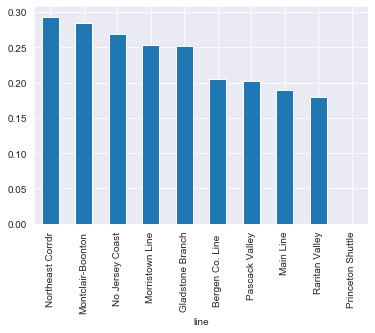

In [76]:
#Exploring long delays
df['long_delay'] = df['w_delay_minutes'] > 5
df.groupby('line')['long_delay'].mean().sort_values(ascending=False).plot(kind='bar')

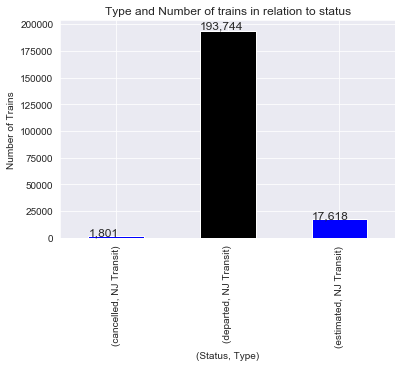

In [81]:
# Looking into the overall on-time,delays and cancellations of NJ Transit
ax = df.groupby(['status', 'type']).size().plot(kind='bar',color=['blue', 'black'])
ax.set_title("Type and Number of trains in relation to status")
ax.set_xlabel("(Status, Type)")
ax.set_ylabel("Number of Trains")
plt.rcParams['figure.figsize'] = (5.0, 5.0)
plt.rcParams.update({'font.size': 12})
for p in ax.patches:
    ax.annotate(str(format(int(p.get_height()), ',d')), (p.get_x(), p.get_height()*1.01));
    

- Most of the trains are on-time, however there are some delays and cancellations

In [82]:
df.groupby('from')['w_delay_minutes'].mean().sort_values(ascending=False).head(10)

from
Harriman                    5.568329
Salisbury Mills-Cornwall    5.408478
Wayne-Route 23              4.686854
Rahway                      4.652998
Linden                      4.641459
Little Falls                4.521507
Otisville                   4.501331
Watsessing Avenue           4.490170
Teterboro                   4.485845
Lincoln Park                4.461826
Name: w_delay_minutes, dtype: float64

In [83]:
df.groupby('to')['w_delay_minutes'].mean().sort_values(ascending=False).head(10)

to
Salisbury Mills-Cornwall    4.960790
Basking Ridge               4.814618
Mountain View               4.684708
Middletown NY               4.552553
Harriman                    4.491787
Wayne-Route 23              4.475358
Aberdeen-Matawan            4.455053
Campbell Hall               4.435212
Tuxedo                      4.432742
Hazlet                      4.425822
Name: w_delay_minutes, dtype: float64

It seems like Salisbury Mills-Cornwall, Harriman and Wayne-Route 23 are the stops with most delay minutes on average of both directions.

In [84]:
#Counting the each value in status
departed = df[df['status'] == 'departed'].status.count()
estimated = df[df['status'] == 'estimated'].status.count()
cancelled = df[df['status'] == 'cancelled'].status.count()
sum_status = departed+estimated+cancelled

In [85]:
df['status'].value_counts()/sum_status

departed     0.908901
estimated    0.082650
cancelled    0.008449
Name: status, dtype: float64

- One more time, we can see that cancelled trains are only a small portion of the overall operation.

# 1.3 Data Modification

In [86]:
# Drop From and To because they already have their unique From_ID and To_ID as dummies to be used.
droplist= ['from','to','long_delay','delay_minutes']
df = df.drop(droplist,1)

- Dropping From and To because they already have their unique From_ID and To_ID as dummies to be used.
- Long delay was created to be used in visualization, we already have this data in delay minutes.
- Delay minutes column has outliers, our new column w_delay_minutes is the winsorized version of the original.

In [87]:
df['date'] = pd.to_datetime(df['date']) 

In [88]:
# Feature Engineering
df['day'] = df['date'].dt.day_name()

In [89]:
# Creating a function to convert the feature with 3 or more values into numerical data.

def func(x):
    if x == 'Monday':
        return 0
    elif x == 'Tuesday':
        return 1
    elif x == 'Wednesday':
        return 2
    elif x == 'Thursday':
        return 3
    elif x == 'Friday':
        return 4
    elif x == 'Saturday':
        return 5
    else:
        return 6

In [90]:
# Creating a function to convert the feature with 3 or more values into numerical data.

def func2(x):
    if x == 'departed':
        return 0
    elif x == 'estimated':
        return 1
    else:
        return 2

In [91]:
# Creating a function to convert the feature with 3 or more values into numerical data.

def func3(x):
    if x == 'NJ Transit':
        return 0
    else:
        return 1

In [92]:
# Getting dummies and dropping the original
df = pd.concat([df.drop('line', axis=1), pd.get_dummies(df['line'])], axis=1)

In [93]:
# Using a function that I created before for data conversion
df['type']=df['type'].apply(func3)

In [94]:
# Getting dummies and dropping the original
df = pd.concat([df.drop('date', axis=1), pd.get_dummies(df['date'])], axis=1)

In [95]:
# Getting dummies and dropping the original
df = pd.concat([df.drop('train_id', axis=1), pd.get_dummies(df['train_id'])], axis=1)

In [96]:
# Using a function that I created before for data conversion
df['status']=df['status'].apply(func2)

In [97]:
# Using a function that I created before for data conversion
df['day']=df['day'].apply(func)

In [98]:
# Dropping this because of its size and memory error
df = df.drop('scheduled_time', axis=1)

In [99]:
# Dropping this because of its size and memory error
df = df.drop('actual_time', axis=1)

In [100]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 213163 entries, 0 to 238688
Columns: 1045 entries, stop_sequence to 7887
dtypes: float64(2), int64(5), uint8(1038)
memory usage: 224.0 MB


In [101]:
df.apply(lambda col: col.drop_duplicates().reset_index(drop=True))


,stop_sequence,from_id,to_id,status,type,w_delay_minutes,day,Bergen Co. Line,Gladstone Branch,Main Line,...,7873,7875,7876,7877,7879,7880,7881,7883,7885,7887
0,1.0,74.0,74.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2.0,40.0,40.0,1.0,NaN,1.150000,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,3.0,4.0,4.0,2.0,NaN,2.116667,2.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4.0,8.0,8.0,NaN,NaN,1.200000,3.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5.0,22.0,22.0,NaN,NaN,0.166667,4.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
665,NaN,NaN,NaN,NaN,NaN,10.816667,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
666,NaN,NaN,NaN,NaN,NaN,10.916667,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
667,NaN,NaN,NaN,NaN,NaN,10.950000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
668,NaN,NaN,NaN,NaN,NaN,10.850000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [102]:
# Removing NaN values
df.dropna()

,stop_sequence,from_id,to_id,status,type,w_delay_minutes,day,Bergen Co. Line,Gladstone Branch,Main Line,...,7873,7875,7876,7877,7879,7880,7881,7883,7885,7887
0,1.0,74,74,0,0,0.000000,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2.0,74,40,0,0,1.150000,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3.0,40,4,0,0,2.116667,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4.0,4,8,0,0,1.200000,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5.0,8,22,0,0,0.166667,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
238684,1.0,63,63,0,0,0.233333,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
238685,2.0,63,38174,0,0,3.000000,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
238686,3.0,38174,118,0,0,3.983333,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
238687,4.0,118,100,0,0,3.683333,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [103]:
df = df.sample(125000)

In [104]:
df.shape

(125000, 1045)

- Unfortunately, I had to reduce the number of rows due to computation issues 

# 2.0 Unsupervised Learning

## 2.1 KMeans

I decided to choose K-means for some reasons. K-means is one of the simplest algorithms which uses unsupervised learning method to solve known clustering issues. It works well with large datasets. Other clustering algorithms with better features tend to be more expensive. More expensive as in slow and memory intensive. As we can see from EDA, our dataset is quite large. In this case, k-means becomes a great solution for clustering. 

I will be using PCA for visualizations.

In [147]:
# Make sure the number of rows divides evenly into four samples.
rows = df.shape[0] - df.shape[0] % 2
df = df.iloc[:rows, :]

X =  df.iloc[:, :1045]

# Standarize and fit the data first 
X_std = StandardScaler().fit_transform(X)

# Data frame to store features and predicted cluster memberships.
ypred = pd.DataFrame()

# Create the two-feature PCA for graphing purposes.
pca = PCA(n_components=2)
X_pcax = pca.fit_transform(X_std)

# Split the data into four equally-sized samples. First we break it in half:
X_half1, X_half2, X_pcahalf1, X_pcahalf2 = train_test_split(
    X_std,
    X_pcax,
    test_size=0.5,
    random_state=123)

# Pass a list of tuples and a counter that increments each time we go
# through the loop. The tuples are the data to be used by k-means,
# and the PCA-derived features for graphing. We use k-means to fit a
# model to the data, then store the predicted values and the two-feature
# PCA solution in the data frame.
for counter, data in enumerate([
    (X_half1, X_pcahalf1),
    (X_half2, X_pcahalf2)]):
    
    # Put the features into ypred.
    ypred['pca_f1' + '_sample' + str(counter)] = data[1][:, 0]
    ypred['pca_f2' + '_sample' + str(counter)] = data[1][:, 1]
    
    # Generate cluster predictions and store them for clusters 2 to 11.
    for nclust in range(2, 11):
        pred = KMeans(n_clusters=nclust, random_state=123).fit_predict(data[0])
        ypred['clust' + str(nclust) + '_sample' + str(counter)] = pred

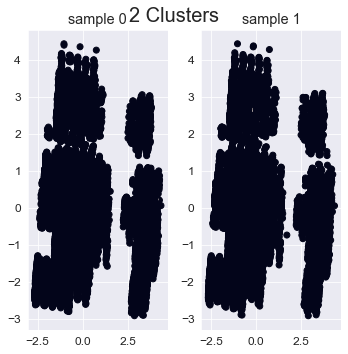

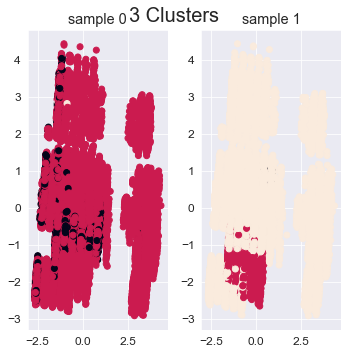

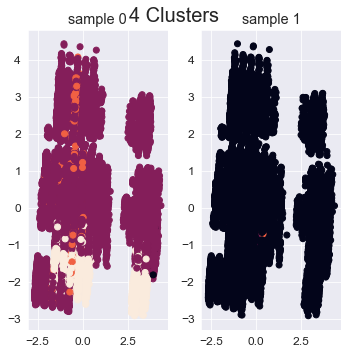

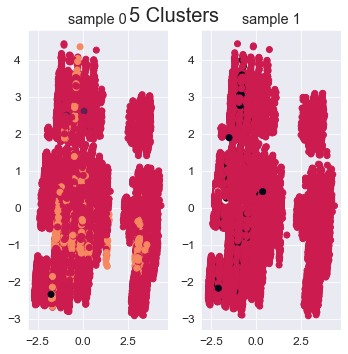

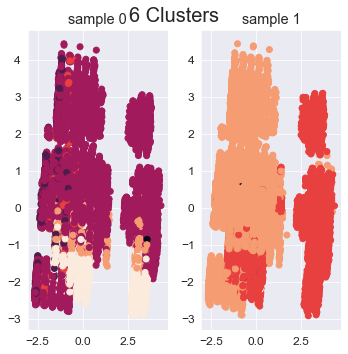

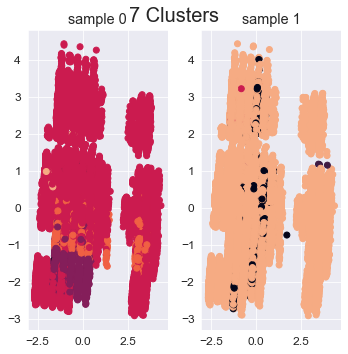

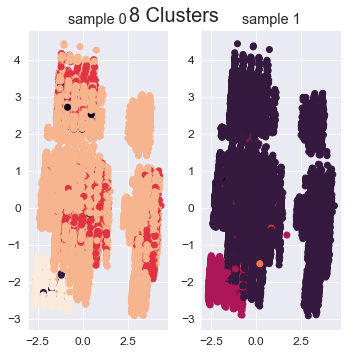

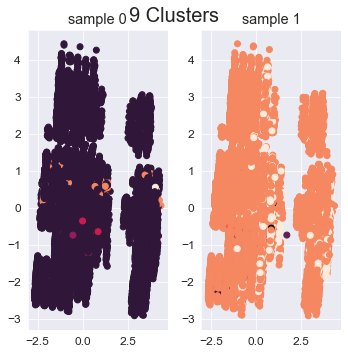

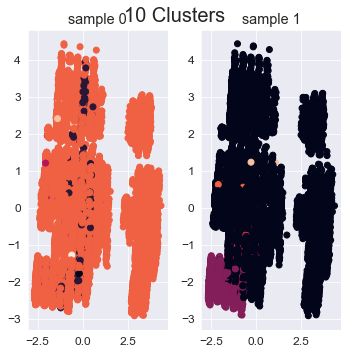

In [148]:
# For each  number of clusters, plot the clusters using the
# pca features for each sample.
for cluster in range(2, 11):
    
    # Make a grid of subplots.
    f, axarr = plt.subplots(1, 2)
    
    # Make a plot for each sample.
    for i in range(2):
        
        # PCA-created features.
        x_sub = ypred['pca_f1_sample{}'.format(i)]
        y_sub = ypred['pca_f2_sample{}'.format(i)]
        
        # Cluster assignments.
        c = ypred['clust{}_sample{}'.format(cluster, i)]
        
        # Assign the subplot to its place on the grid.
        axarr[i].scatter(x_sub, y_sub, c=c)
        axarr[i].set_title('sample {}'.format(i))
        axarr[i].set_xlim()
        axarr[i].set_ylim()
    
    # Space out the plots so that the headings don't overlap axis values.
    plt.suptitle('{} Clusters'.format(cluster), fontsize=20)
    plt.tight_layout()
    plt.show()

In [149]:
# Run k means model
for k in np.arange(2, 11, 1):
    for X_std in [X]: 
        result = KMeans(n_clusters=k, random_state=123, n_jobs=-1, covariance_type="full", tol=0.001).fit(X_std)
        labels = result.labels_
        silhouette = metrics.silhouette_score(X_std, labels, metric='euclidean')
        print('K: {}, silhouette: {}'.format(k, silhouette))

K: 2, silhouette: 0.8207167252265268
K: 3, silhouette: 0.9771371417661077
K: 4, silhouette: 0.9859780974263765
K: 5, silhouette: 0.9792448181367747
K: 6, silhouette: 0.9730650760261702
K: 7, silhouette: 0.9785873415565247
K: 8, silhouette: 0.9837748482591298
K: 9, silhouette: 0.9840769951220051
K: 10, silhouette: 0.9761710407359229


I will be picking one of the high number of clusters so that our graphs could show more detailed version of the answers. Within the high number of clusters, K:9 has the highest score.

In [150]:
# Run k means model only with 9 clusters
cluster9 = KMeans(n_clusters=9, random_state=123, n_jobs=-1).fit(X_std)
labels = cluster9.labels_
metrics.silhouette_score(X_std, labels, metric='euclidean')

0.9840769951220051

Which day of the week has the longest delays in each cluster?

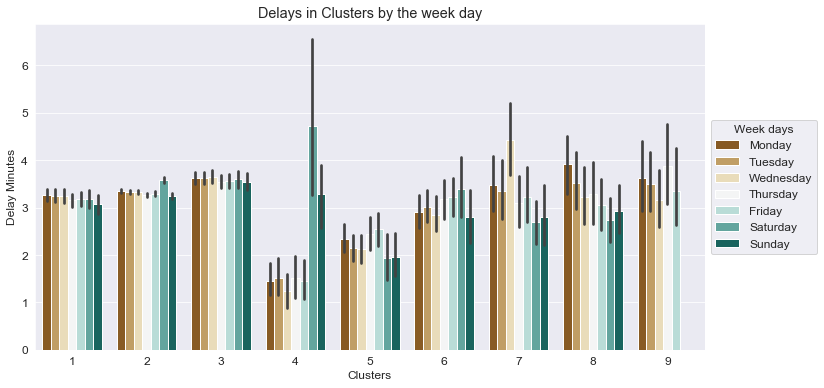

In [151]:
# Using Seaborn Barplot for the visualization
days= ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
ax = sns.barplot(x=labels+1,y=df['w_delay_minutes'], data=df, palette="BrBG", hue='day')
ax.figure.set_size_inches(12,6)
ax.set(xlabel='Clusters', ylabel='Delay Minutes')
ax.set_title("Delays in Clusters by the week day")
h, l = ax.get_legend_handles_labels()
ax.legend(h, days, title="Week days", loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

 - In five clusters out of nine, Mondays are the worst. Saturdays are close to Mondays with having the longest delays in three of the clusters. Finally, there is one cluster (#7) in which Wednesday is the day with the longest delays.

- According to the graph, NJ Transit needs to pay extra attention and should try to fix the delays on Mondays and Saturdays. The average delay is about 3 minutes however if you add up to the lost time exponentially in millions of commuters, it creates a big loss for the people. 

Does the stop sequence affect the status of trains in each cluster? 

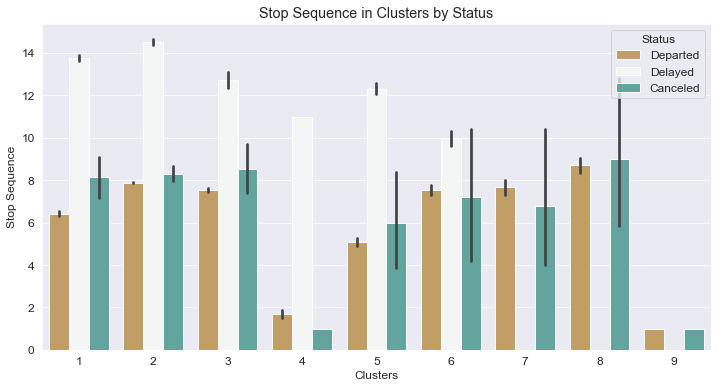

In [152]:
# Using Seaborn Barplot for the visualization
status = ['Departed','Delayed','Canceled']
ax = sns.barplot(x=labels+1,y=df['stop_sequence'], data=df, palette="BrBG", hue='status')
ax.figure.set_size_inches(12,6)
ax.set(xlabel='Clusters', ylabel='Stop Sequence')
ax.set_title("Stop Sequence in Clusters by Status")
h, l = ax.get_legend_handles_labels()
ax.legend(h, status, title="Status")

plt.show()

- There are delayed trains in only 6 clusters. When we look at the graph, we can see that all delayed trains are correlated to high stop sequence. In addition to that, we can see the cancellation numbers get higher as the stop sequence gets higher. 

## 2.2 Gaussian Mixture Models 

After using a hard clustering method like K-means, I wanted to use a soft clustering method like Gaussian Mixture Models. K-means only considers the mean to update the centroid while GMM considers the mean as well as the variance of the data. So instead of using a distance-based model, I will now use a distribution-based model. A Gaussian Mixture Model tends to group the data points belonging to a single distribution together. This model is stronger than K-means, however, its computation time is longer.

- I will be using t-SNE for the dimensionality reduction and visualizations of cluster groups

In [51]:
# Make sure the number of rows divides evenly into four samples.
rows = df.shape[0] - df.shape[0] % 2
df = df.iloc[:rows, :]

X = df.iloc[:, :1045]
# Standarize and fit the data  
X_std = StandardScaler().fit_transform(X)

# Data frame to store features and predicted cluster memberships.
ypred = pd.DataFrame()

# Create the two-feature t-SNE for graphing purposes.
tsne = TSNE(n_components=2, verbose=1, perplexity=10, n_iter=300)
X_tsne = tsne.fit_transform(X_std)
# Split the data into four equally-sized samples. First we break it in half:
X_half1, X_half2, X_tsnehalf1, X_tsnehalf2 = train_test_split(
    X_std,
    X_tsne,
    test_size=0.5,
    random_state=123)

# Pass a list of tuples and a counter that increments each time we go
# through the loop. The tuples are the data to be used by GMM,
# and the t-SNE-derived features for graphing. We use k-means to fit a
# model to the data, then store the predicted values and the two-feature
# t-SNE solution in the data frame.
for counter, data in enumerate([
    (X_half1, X_tsnehalf1),
    (X_half2, X_tsnehalf2)]):
    
    # Put the features into ypred.
    ypred['pca_f1' + '_sample' + str(counter)] = data[1][:, 0]
    ypred['pca_f2' + '_sample' + str(counter)] = data[1][:, 1]
    
    # Generate cluster predictions and store them for clusters 2 to 10.
    for nclust in range(2, 11):
        pred = GaussianMixture(n_components=nclust, random_state=123).fit_predict(data[0])
        ypred['clust' + str(nclust) + '_sample' + str(counter)] = pred

[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 125000 samples in 59.403s...
[t-SNE] Computed neighbors for 125000 samples in 181.806s...
[t-SNE] Computed conditional probabilities for sample 1000 / 125000
[t-SNE] Computed conditional probabilities for sample 2000 / 125000
[t-SNE] Computed conditional probabilities for sample 3000 / 125000
[t-SNE] Computed conditional probabilities for sample 4000 / 125000
[t-SNE] Computed conditional probabilities for sample 5000 / 125000
[t-SNE] Computed conditional probabilities for sample 6000 / 125000
[t-SNE] Computed conditional probabilities for sample 7000 / 125000
[t-SNE] Computed conditional probabilities for sample 8000 / 125000
[t-SNE] Computed conditional probabilities for sample 9000 / 125000
[t-SNE] Computed conditional probabilities for sample 10000 / 125000
[t-SNE] Computed conditional probabilities for sample 11000 / 125000
[t-SNE] Computed conditional probabilities for sample 12000 / 125000
[t-SNE] Computed conditional prob

[t-SNE] Computed conditional probabilities for sample 124000 / 125000
[t-SNE] Computed conditional probabilities for sample 125000 / 125000
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 106.014893
[t-SNE] KL divergence after 300 iterations: 6.246857


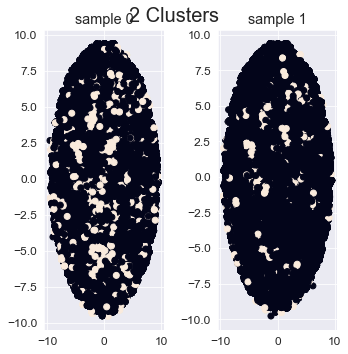

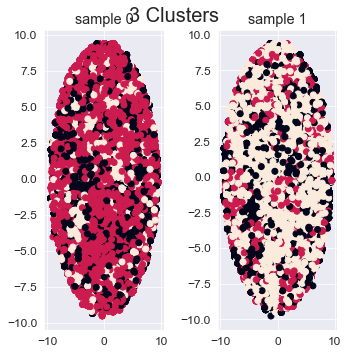

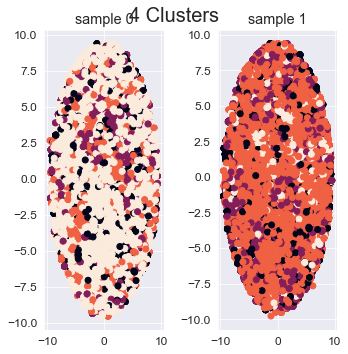

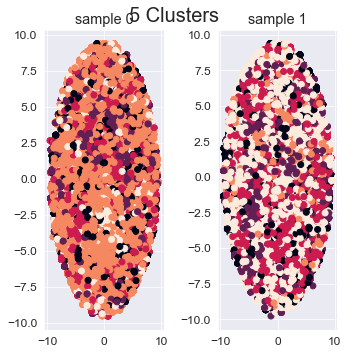

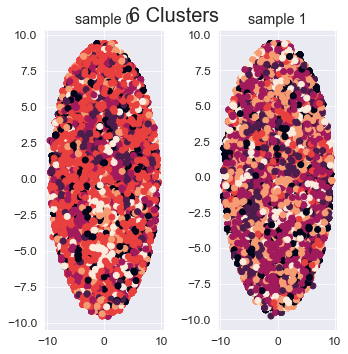

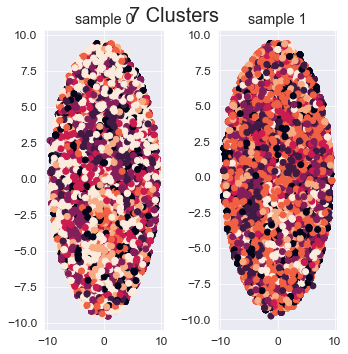

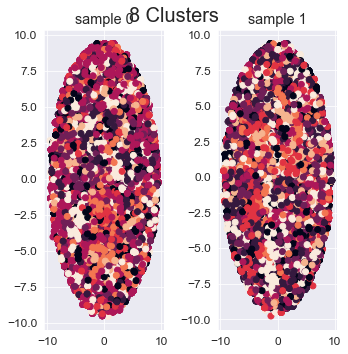

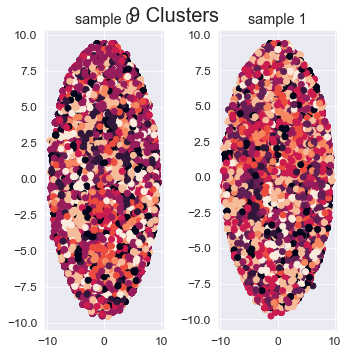

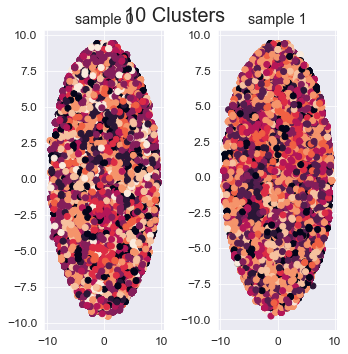

In [52]:
# For each  number of clusters, plot the clusters using the
# t-SNE features for each sample.
for cluster in range(2, 11):
    
    # Make a grid of subplots.
    f, axarr = plt.subplots(1, 2)
    
    # Make a plot for each sample.
    for i in range(2):
        
        # t-SNE-created features.
        x_sub = ypred['tsne_f1_sample{}'.format(i)]
        y_sub = ypred['tsne_f2_sample{}'.format(i)]
        
        # Cluster assignments.
        c = ypred['clust{}_sample{}'.format(cluster, i)]
        
        # Assign the subplot to its place on the grid.
        axarr[i].scatter(x_sub, y_sub, c=c)
        axarr[i].set_title('sample {}'.format(i))
        axarr[i].set_xlim()
        axarr[i].set_ylim()
    
    # Space out the plots so that the headings don't overlap axis values.
    plt.suptitle('{} Clusters'.format(cluster), fontsize=20)
    plt.tight_layout()
    plt.show()

In [53]:
# Run Gaussian Mixture  model
for k in np.arange(2, 11, 1):
    for X_std in [X]: 
        clusterer = GaussianMixture(n_components=k, random_state=123).fit_predict(X_std)
        silhouette = metrics.silhouette_score(X_std, clusterer, metric='euclidean')
        print('K: {}, silhouette: {}'.format(k, silhouette))

K: 2, silhouette: 0.8212370964144198
K: 3, silhouette: 0.9775067377085016
K: 4, silhouette: 0.9858293559267303
K: 5, silhouette: 0.9791966935354918
K: 6, silhouette: 0.9726108610181766
K: 7, silhouette: 0.9781568601011982
K: 8, silhouette: 0.9836801863027415
K: 9, silhouette: 0.9839907086499631
K: 10, silhouette: 0.9759562522568133


The results are quite high and very close to K-means scores. I will be picking the Cluster 9 again because it has the highest score in the high number clusters.

In [54]:
# Run Gaussian Mixture model only with 9 clusters
labels = GaussianMixture(n_components=9, random_state=123).fit_predict(X_std)
print(metrics.silhouette_score(X_std, labels, metric='euclidean'))

0.9839907086499631


Which day of the week has the longest delays in each cluster?

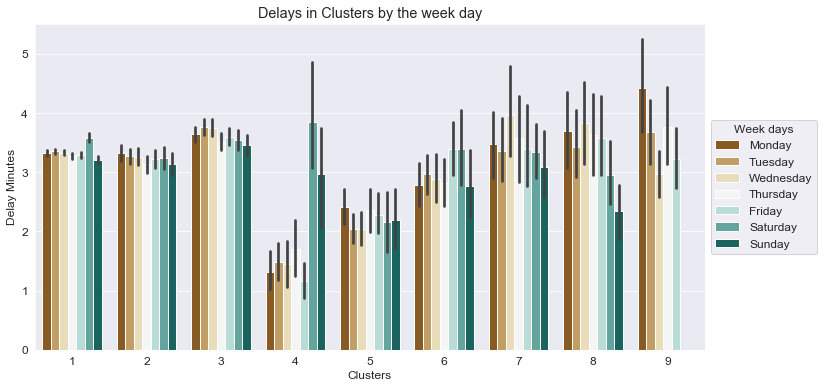

In [56]:
# Using Seaborn Barplot for the visualization
days= ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
ax = sns.barplot(x=labels+1,y=df['w_delay_minutes'], data=df, palette="BrBG", hue='day')
ax.figure.set_size_inches(12,6)
ax.set(xlabel='Clusters', ylabel='Delay Minutes')
ax.set_title("Delays in Clusters by the week day")
h, l = ax.get_legend_handles_labels()
ax.legend(h, days, title="Week days", loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

- We have a three-way tie in our graph. Mondays, Wednesdays, and Saturdays are equally distributed with the longest delays. In comparison to K-means, this graph is very balanced with GMM. In the K=means graph, we had Mondays in 6 clusters, Saturdays in 2 and Wednesday in 1.

Does the stop sequence affect the status of trains in each cluster?

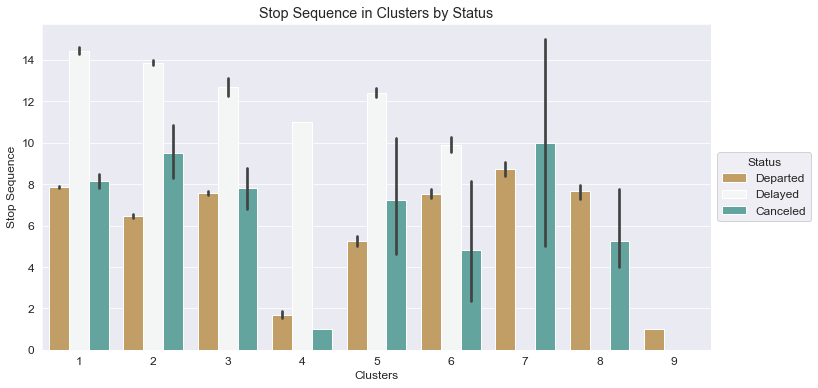

In [57]:
# Using Seaborn Barplot for the visualization
status = ['Departed','Delayed','Canceled']
ax = sns.barplot(x=labels+1,y=df['stop_sequence'], data=df, palette="BrBG", hue='status')
ax.figure.set_size_inches(12,6)
ax.set(xlabel='Clusters', ylabel='Stop Sequence')
ax.set_title("Stop Sequence in Clusters by Status")
h, l = ax.get_legend_handles_labels()
ax.legend(h, status, title="Status", loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

Looking at the clusters, we can easily see the pattern between delayed trains and the high stop sequence. This part is very similar to K-means model. However, the cancellations numbers and the stop sequence relationship is much more clear  in this graph compared to K-means graph. After using a soft cluster in which a data point could be belong to more than one cluster,  the stop sequence of the cancelled trains increases.


# 3.0 Supervised Learning

### Class Imbalance

- Imbalanced data typically refers to a problem with classification problems where the classes are not represented equally.

- It is the case where our accuracy measures tell the story that we have excellent accuracy (such as 90%), but the accuracy is only reflecting the underlying class distribution.

- Most machine learning algorithms work best when the number of samples in each class are about equal. This is because most algorithms are designed to maximize accuracy and reduce error.

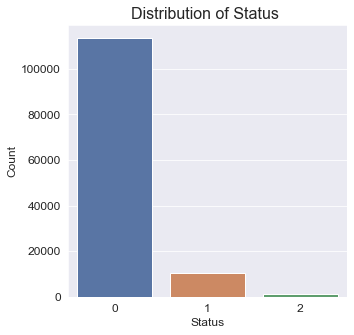

In [47]:
#Use Seaborn Countplot to check Class Imbalance
plt.figure(figsize=(5,5))
sns.countplot(x = df.status,palette='deep')
plt.xlabel('Status', fontsize= 12)
plt.ylabel('Count', fontsize= 12)
plt.title("Distribution of Status ",fontsize= 16)
plt.show()

In [48]:
# Check if we have an even distribution of Status
df['status'].value_counts()

0    113504
1     10434
2      1062
Name: status, dtype: int64

It is clear that we have a Class Imbalance problem.

 - 91% of the data is actually 'Departed' for train status.

 - Since this dataset has imbalanced data , I will downsample and upsample the data so that there will be an even distribution.

In [49]:
# Lets resample to 3522 to meet the total values
# So less nonfraudulent samples.
middle = df[df.status == 0]
majority = df[df.status ==1]
minority = df[df.status ==2]

# Upsample middle class
middle_upsampled = resample(middle, 
                                 replace=True,     # sample with replacement
                                 n_samples=60000) 

# Downsample majority class
majority_downsampled = resample(majority, 
                                 replace=True,     # sample with replacement
                                 n_samples=60000)  

# Upsample minority class
minority_upsampled = resample(minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=60000)  
 
# Combine downsampled majority class with minority class
resampled = pd.concat([middle_upsampled, majority_downsampled, minority_upsampled])
 
# Display new class counts
resampled.status.value_counts()

2    60000
1    60000
0    60000
Name: status, dtype: int64

I decided to balance our values at 60k because lesser would cause a big loss of the original data of on-time trains and more than 60k would make our data unnecessarily large.

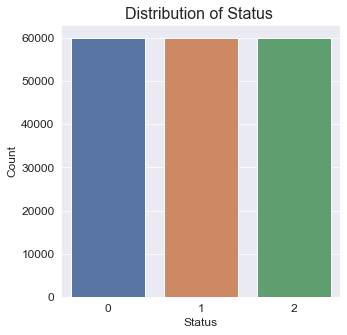

In [50]:
#Use Seaborn Countplot to check Class Imbalance
plt.figure(figsize=(5,5))
sns.countplot(x = resampled.status,palette='deep')
plt.xlabel('Status', fontsize= 12)
plt.ylabel('Count', fontsize= 12)
plt.title("Distribution of Status ",fontsize= 16)
plt.show()

In [51]:
# Set up variables
X = resampled.drop('status',1)
Y = resampled['status']

## 3.1 Dimensionality Reduction - PCA

In [52]:
# Prepare the data first for PCA
X = resampled.drop('status',1)

# Standarize and fit the data first 
X = StandardScaler().fit_transform(X)

In [53]:
# Use 200 components since it will explain most of the variance.
pca = PCA(n_components=100)

# Fit and transform the PCA model.
pca.fit(X)
X_pca = pca.transform(X)

#Take a look at the transformation
print("original shape:   ", X.shape)
print("transformed shape:", X_pca.shape)

original shape:    (180000, 1044)
transformed shape: (180000, 100)


 Here, I use PCA before my modeling because the high number of features(dimensions) are creating an exponentially growing computation time and I want to prevent too long of a computation time.

## 3.2 PCA - Decision Tree

In [54]:
# Set up variables
X = X_pca
Y = resampled['status']

# Create training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=5)

In [55]:
# Initialize the model.
decision_tree_classifier = DecisionTreeClassifier()

In [56]:
#Set up parameters
parameter_grid = {'max_depth': np.arange(90,95),
                  'max_features': ['auto', 'sqrt', 'log2'],
                  'criterion': ['entropy','gini']}


# Use the grid
grid_search = GridSearchCV(decision_tree_classifier, param_grid = parameter_grid,scoring='accuracy',
                          n_jobs=-1, cv =3,refit=False)
# Fit the grid
grid_search.fit(X_train, y_train)

# Return best parameters and best score
print ("Best Score: {}".format(grid_search.best_score_))
print ("Best params: {}".format(grid_search.best_params_))

Best Score: 0.9545625
Best params: {'criterion': 'gini', 'max_depth': 92, 'max_features': 'auto'}


In [76]:
#Run the model 
decision_tree_classifier = DecisionTreeClassifier(criterion='gini',
    max_features='auto',
    max_depth=92,
    random_state = 1337)

decision_tree_classifier.fit(X_train, y_train)

y_pred = decision_tree_classifier.predict(X_test)

In [77]:
cross_val_score(decision_tree_classifier, X_train, y_train, cv=10)

array([0.9702104 , 0.96590515, 0.96764114, 0.96923825, 0.97      ,
       0.96798611, 0.96701389, 0.9672894 , 0.96819224, 0.96819003])

In [78]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[11060,   898,    18],
       [   87, 11816,     0],
       [    0,     0, 12121]], dtype=int64)

In [79]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.92      0.96     11976
           1       0.93      0.99      0.96     11903
           2       1.00      1.00      1.00     12121

    accuracy                           0.97     36000
   macro avg       0.97      0.97      0.97     36000
weighted avg       0.97      0.97      0.97     36000



- The accuracy of the decision tree was high. This model was able to obtain such a high accuracy by using the large amount of depth to explain the variance (lower the gini) of the dataset to the minimum allowing the decision tree to become a strong classifier.

- The decision tree is a relatively strong performer in this dataset since it was quick and it's had the one of the highest level of accuracy.

## 3.3 PCA - Logistic Regression

In [54]:
# Set up variables
X = X_pca
Y = resampled['status']

# Create training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=5)

In [55]:
# Initialize the model.
lr = LogisticRegression()

In [71]:
parameter_grid = {'C': [10,25,50,55],
                  'penalty' :['l1', 'l2']}

# Use the grid
grid_search = GridSearchCV(lr, param_grid = parameter_grid,scoring='accuracy',
                          n_jobs=-1, cv =3,refit=False)
# Fit the grid
grid_search.fit(X_train, y_train)

# Return best parameters and best score
print ("Best Score: {}".format(grid_search.best_score_))
print ("Best params: {}".format(grid_search.best_params_))

Best Score: 0.7074722222222222
Best params: {'C': 25, 'penalty': 'l1'}


In [72]:
lr = LogisticRegression(penalty='l1', dual=False, tol=0.0001, 
                           C=25, random_state=123)

lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

In [73]:
cross_val_score(lr, X_train, y_train, cv=10)

array([0.70647872, 0.70974238, 0.70536768, 0.70779807, 0.71347222,
       0.710625  , 0.70236111, 0.70796583, 0.70997986, 0.71127934])

In [74]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[ 6801,  3799,  1376],
       [ 3354,  7463,  1086],
       [  562,   182, 11377]], dtype=int64)

In [75]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.63      0.57      0.60     11976
           1       0.65      0.63      0.64     11903
           2       0.82      0.94      0.88     12121

    accuracy                           0.71     36000
   macro avg       0.70      0.71      0.71     36000
weighted avg       0.70      0.71      0.71     36000



For the logistic regression model, I had chose to use the ridge regularization to penalize this model due to the amount of rows I had in this dataset. Using the ridge regularization allowed me to avoid the overfitting of the coefficients and I want to avoid increasing the size of the coefficient because it means that the feature related to that coefficient will have more weight on the model itself. In order to avoid overweighting the importance of the features, I had to use the ridge regularization.

Looking at the best penalty parameter, I can see that there was a stronger regularization since it was 1. This model did worse in terms of accuracy compared to the decision tree and KNN, but its computation time was pretty fast which is noteworthy.

## 3.4 PCA KNN

In [61]:
# Set up variables
X = X_pca
Y = resampled['status']

# Create training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=5)

In [62]:
# Initialize the model.
knn = KNeighborsClassifier()


In [68]:
parameter_grid = {'n_neighbors' :[1,5,10,50,100]}


# Use the grid
grid_search = GridSearchCV(knn, param_grid = parameter_grid,scoring='accuracy',
                          n_jobs=-1, cv =3,refit=False)
# Fit the grid
grid_search.fit(X_train, y_train)

# Return best parameters and best score
print ("Best Score: {}".format(grid_search.best_score_))
print ("Best params: {}".format(grid_search.best_params_))

Best Score: 0.9418819444444444
Best params: {'n_neighbors': 1}


In [64]:
knn = KNeighborsClassifier(n_neighbors = 1 )

knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

In [65]:
cross_val_score(knn, X_train, y_train, cv=10)

array([0.96229429, 0.96243316, 0.96111381, 0.96236372, 0.96236111,
       0.96326389, 0.96326389, 0.96353913, 0.96152511, 0.96437005])

In [66]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[10937,  1027,    12],
       [  105, 11798,     0],
       [    0,     0, 12121]], dtype=int64)

In [67]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.91      0.95     11976
           1       0.92      0.99      0.95     11903
           2       1.00      1.00      1.00     12121

    accuracy                           0.97     36000
   macro avg       0.97      0.97      0.97     36000
weighted avg       0.97      0.97      0.97     36000



Although I used PCA to help me filter out the important features for this model, the fact that it only needed one neighbor to classify if there will be a delay or not is concerning. However, after using a confusion matrix and the classification report to look at the model's ability to recognize false positives/negatives, the results felt relaxing. I saw that this model was able to explain about 96% of the accuracy generated by three different evaluation procedures. As a result, I stopped worrying about it. The overall accuracy is better than Logistics Regression model and very close to Decision Tree model.

# 4.0 Conclusion

Comparing the two dimentionality reduction techniques that I used in the unsupervised learning part, PCA is a clear winner in terms of computation time and visual display.Clusters are more clear in the PCA visualizations. This is understanble because t-SNE is known for its success in image-based datasets, not in CSV-based datasets.

I had two questions to answer in the unsupervised part. Based on the results, I decided that K-means is a better model to use in this case for a couple reasons. The first one is that K-means was able to isolate the special groups better than Gaussian Mixture Models. To be more specific, the special group for the first question was Monday. The question was asking which specific day has the longest delays. In the GMM, we had a three-way tie and did not have a precise answer. Again, we were able to see that delays were very high in relation to stop sequence for the second question. However, groups were not very isolated in the GMM version. Additionally, K-means is way faster than GMM in terms of computation time. Working with a large dataset with a lot of dimensions, K-means saved me for time than GMM did. 

In the supervised learning my outcome dependent(y variable) was Status. To conclude, the best performing model will be the Decision Tree model due to its accuracy and computation time. It took a minute only for it achieve a strong result and compared to other fast computation models like KNN and Logistic Regression, it performed the best. The runner up in this case will have to be the KNN model since that model was not so slow but it required a good amount of time and performed almost same like Decision Tree model.

Ultimately, this project was a time burner and there probably could've been a more efficient way to do the project besides waiting a long time for the data to be ready. Another blemish on this project is that I spent a lot of time amassing a lot of data.